In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nitishkd","key":"43419bc8e210070cef36b2f1db9201db"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets download -d jaimebadiola/bitcoin-tweets-and-price

bitcoin-tweets-and-price.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
!unzip bitcoin-tweets-and-price.zip

Archive:  bitcoin-tweets-and-price.zip
replace Data_To_Hourervals_no_filter.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Data_To_Hourervals_no_filter.csv  


In [20]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [49]:
coinbase = pd.read_csv("Data_To_Hourervals_no_filter.csv",sep=";")
cb_index = coinbase.index.ravel()

print(list(coinbase.columns), "\nSHAPE ::", coinbase.shape)
for i in coinbase.columns:
    print(i, "::", coinbase[i].dtype)

# Declaring number for random state for reproducibility
rstate=123

coinbase.head()


['Date', 'Compound_Score', 'n', 'Count_Negatives', 'Count_Positives', 'Count_Neutrals', 'Sent_Negatives', 'Sent_Positives', 'Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)'] 
SHAPE :: (12936, 14)
Date :: object
Compound_Score :: float64
n :: float64
Count_Negatives :: float64
Count_Positives :: float64
Count_Neutrals :: float64
Sent_Negatives :: float64
Sent_Positives :: float64
Open :: float64
High :: float64
Low :: float64
Close :: float64
Volume (BTC) :: object
Volume (Currency) :: object


,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
0,01/08/2017 0:00,0.097156,1027.0,148.0,403.0,476.0,-0.504061,0.432704,2855.81,2863.06,2823.00,2825.92,184.02,"522951,00"
1,01/08/2017 1:00,0.064507,778.0,143.0,239.0,396.0,-0.381007,0.437953,2823.01,2860.02,2821.01,2853.38,77.3,219605.16
2,01/08/2017 2:00,0.119218,836.0,118.0,333.0,385.0,-0.394999,0.439269,2846.27,2858.04,2837.31,2841.60,135.83,386739.15
3,01/08/2017 3:00,0.004163,984.0,262.0,279.0,443.0,-0.431913,0.420278,2841.84,2863.88,2837.73,2862.93,143.2,408360.03
4,01/08/2017 4:00,0.065608,751.0,133.0,237.0,381.0,-0.405835,0.435645,2862.92,2876.00,2848.11,2874.99,222.53,637045.88


In [61]:
df = coinbase
df[df[:]==""] = np.NaN
a = df.fillna(method='ffill')
a = a.drop(['Date'], axis=1)
# Volume (Currency)
a = a.drop(["Volume (Currency)"], axis=1)
a = a.drop(["Volume (BTC)"], axis=1)
print(a.head())
SC = MinMaxScaler()
a = SC.fit_transform(a)


   Compound_Score       n  Count_Negatives  Count_Positives  Count_Neutrals  \
0        0.097156  1027.0            148.0            403.0           476.0   
1        0.064507   778.0            143.0            239.0           396.0   
2        0.119218   836.0            118.0            333.0           385.0   
3        0.004163   984.0            262.0            279.0           443.0   
4        0.065608   751.0            133.0            237.0           381.0   

   Sent_Negatives  Sent_Positives     Open     High      Low    Close  
0       -0.504061        0.432704  2855.81  2863.06  2823.00  2825.92  
1       -0.381007        0.437953  2823.01  2860.02  2821.01  2853.38  
2       -0.394999        0.439269  2846.27  2858.04  2837.31  2841.60  
3       -0.431913        0.420278  2841.84  2863.88  2837.73  2862.93  
4       -0.405835        0.435645  2862.92  2876.00  2848.11  2874.99  


(12936, 4)


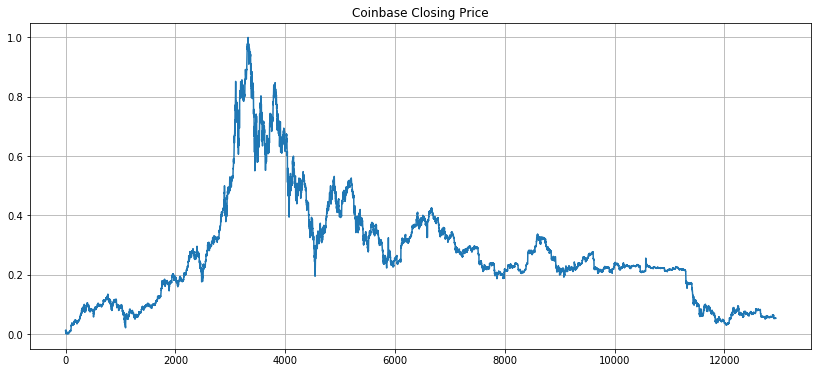

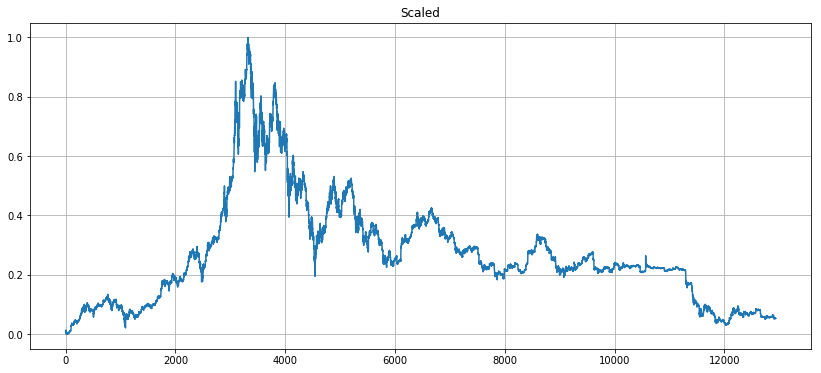

In [69]:
close_price = a[:, 7].reshape(-1,1)
plt.figure(figsize=(14,6))
plt.title("Coinbase Closing Price")
plt.grid()
plt.plot(close_price)

new_dataset = a[:, [2,3,4,10]]
sc = MinMaxScaler()
close_priceSC = sc.fit_transform(new_dataset)
plt.figure(figsize=(14,6))
plt.title("Scaled")
plt.grid()
print(close_priceSC.shape)
plt.plot(close_priceSC[:, 3])

In [0]:
X = []
for i in range(60, len(close_priceSC)):
    U = close_priceSC[i-60:i, :]
    X.append(U)   
X = np.array(X)
    
    

In [98]:
np.unique(close_priceSC)

array([0.00000000e+00, 2.04708291e-04, 2.10372166e-04, ...,
       9.94628497e-01, 9.96677873e-01, 1.00000000e+00])

In [122]:
print(X.shape)
X_train = X[:10000]
X_test = X[10000:]

y_train = close_priceSC[60:10060,3]
y_test = close_priceSC[10060:, 3]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12876, 60, 4)
(10000, 60, 4)
(10000,)
(2876, 60, 4)
(2876,)


ValueError: ignored

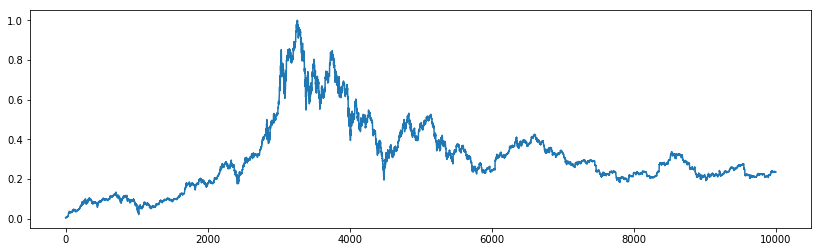

In [123]:
plt.figure(figsize=(14,4))
plt.plot(range(10000),y_train)
plt.plot(range(10000, len(close_priceSC)), y_test)
plt.legend(["Training", "Test"])
plt.grid()


In [124]:
print(X_train.shape)
# X_train = X_train.reshape(-1,60,3)
# X_test = X_test.reshape(-1,60,3)

(10000, 60, 4)


In [136]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=500)

Epoch 1/50
10000/10000 [==============================] - 10s 985us/step - loss: 0.1246
Epoch 2/50
10000/10000 [==============================] - 7s 652us/step - loss: 0.0582
Epoch 3/50
10000/10000 [==============================] - 7s 654us/step - loss: 0.0475
Epoch 4/50
10000/10000 [==============================] - 7s 658us/step - loss: 0.0422
Epoch 5/50
10000/10000 [==============================] - 7s 742us/step - loss: 0.0395
Epoch 6/50
10000/10000 [==============================] - 7s 692us/step - loss: 0.0373
Epoch 7/50
10000/10000 [==============================] - 7s 660us/step - loss: 0.0368
Epoch 8/50
10000/10000 [==============================] - 7s 655us/step - loss: 0.0358
Epoch 9/50
10000/10000 [==============================] - 7s 662us/step - loss: 0.0342
Epoch 10/50
10000/10000 [==============================] - 7s 654us/step - loss: 0.0332
Epoch 11/50
10000/10000 [==============================] - 7s 652us/step - loss: 0.0334
Epoch 12/50
10000/10000 [===============

In [0]:
# regressor = tf.keras.models.load_model('model.h5')

In [138]:
%%time
y_pred = regressor.predict(X_test)
print(y_pred.shape, X_test.shape)

(2876, 1) (2876, 60, 4)
CPU times: user 17.1 s, sys: 1.61 s, total: 18.7 s
Wall time: 11.7 s


In [0]:
def systematic_mean_absolute_percentage_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    for i in range(n):
        num = np.abs(y_pred[i] - y_true[i])
        dem = (np.abs(y_true[i]) + np.abs(y_pred[i]))/2
        res += num/dem
    res = np.squeeze(res)
    return 100*(res/n)

In [0]:
import numpy as np
def mean_absolute_scaled_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    dem = 0
    num = 0
    for i in range(n-1):
        dem += y_true[i+1] - y_true[i]
    for i in range(n):
        num = abs(y_pred[i] - y_true[i])
        num = np.squeeze(num)
        res += num/dem
    res = np.squeeze(res)
    #print(num, dem, res)
    return res/n

In [141]:
MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error is : ", MAE)

Mean Absolute Error is :  0.003571749861077514


Text(0, 0.5, 'Price')

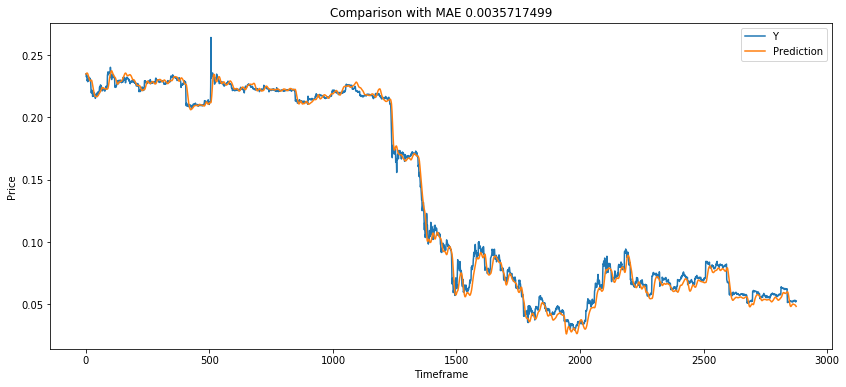

In [142]:
plt.figure(figsize=(14,6))
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [143]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred)
print("Mean Squared Error is : ", MSE)

Mean Squared Error is :  2.750869596347295e-05


In [144]:
SMAPE = systematic_mean_absolute_percentage_error(y_test, y_pred)
print("Systematic Mean Absolute Percentage Error is : ", SMAPE)

Systematic Mean Absolute Percentage Error is :  4.489084808816498


In [145]:
MASE = mean_absolute_scaled_error(y_test, y_pred)
print("Mean Absolute Scaled Error is : ",MASE)

Mean Absolute Scaled Error is :  -0.019605236513528638
